In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt

########################
# Find qslam modules
########################
sys.path.append('../qslam/')
sys.path.append('../paduaq/')

from hardware import Node
from visualiserisk import cm2inch, HEATMAP
from riskanalysis import EngineeredTruth
from true_functions import true_function, generate_data_qubits_coords

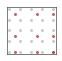

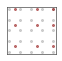

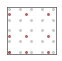

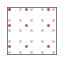

In [2]:
# Add an extra case corresponding to simple assignment

data_qubits = generate_data_qubits_coords(25, flag='uniform')
sensing_qubits = [(x, 0.75) for x in [-0.75, 0.25, 1.0]] + [(x, -0.25) for x in [-0.75, 0.25, 1.0]]
sensing_qubits += [(x, -1.) for x in [-0.75, 0.25, 1.0]]
sensing_qubits =  np.asarray(sensing_qubits[::-1])

# Create sensing grids for each of the 4 orientations
sensing_qubit_rot0 = np.asarray([sensing_qubits[:, 0], sensing_qubits[:, 1]])
sensing_qubit_rot1 = np.asarray([sensing_qubits[:, 0], -sensing_qubits[:, 1]])
sensing_qubit_rot2 = np.asarray([-sensing_qubits[:, 0], sensing_qubits[:, 1]])
sensing_qubit_rot3 = np.asarray([-sensing_qubits[:, 0], -sensing_qubits[:, 1]])

SENSING_LIST = [sensing_qubit_rot0, sensing_qubit_rot1, sensing_qubit_rot2, sensing_qubit_rot3]
GROUP_0, GROUP_1, GROUP_2, GROUP_3 =  {}, {}, {}, {}
GROUP_LIST = [GROUP_0, GROUP_1, GROUP_2, GROUP_3]

for idx_rotation in range(4):
    
    for idx in range(9):

        item = SENSING_LIST[idx_rotation][:, idx]
        GROUP_LIST[idx_rotation]['('+str(item[0])+', '+str(item[1])+')'] = []

    plt.figure(figsize=(cm2inch(2.2),cm2inch(2.2)))

    plt.plot(np.asarray(data_qubits)[:,0],np.asarray(data_qubits)[:,1], '.',
             markeredgecolor='darkgrey', 
             markerfacecolor='darkgrey',
             label="Data Qubits", ms=4, alpha=.5)

    plt.plot(SENSING_LIST[idx_rotation][0,:],  SENSING_LIST[idx_rotation][1, :], '.',
             markeredgecolor='darkred', 
             markerfacecolor='darkred',
             label="Sensor Qubits", ms=4, alpha=0.5)

    plt.xticks([])
    plt.yticks([])
    plt.savefig('data_figs/LocalNeighborhoodAssignment_GridRot_'+str(idx_rotation)+'.svg', format='svg', dpi=400)
    plt.show()

    
GROUP_0['(-0.75, -0.25)'] = [5, 6, 10, 11]
GROUP_0['(1.0, -0.25)']=[9, 14]
GROUP_0['(1.0, 0.75)']=[ 19, 24]
GROUP_0['(-0.75, 0.75)']=[15, 16, 20, 21]
GROUP_0['(1.0, -1.0)']=[4]
GROUP_0['(0.25, 0.75)']=[17, 18, 22, 23]
GROUP_0['-0.75, -1.0']=[0, 1]
GROUP_0['(0.25, -1.0)']=[2,3]
GROUP_0['(0.25, -0.25)']=[7,8,12,13]

GROUP_1['(-0.75, 0.25)']=[10, 11, 15, 16]
GROUP_1['(-0.75, 1.0)']=[20, 21]
GROUP_1['(1.0, 0.25)']=[14, 19]
GROUP_1['(1.0, 1.0)']=[24]
GROUP_1['(0.25, 1.0)']=[22, 23]
GROUP_1['(-0.75, -0.75)']=[0, 1, 5, 6]
GROUP_1['(0.25, -0.75)']=[2,3, 7,8]
GROUP_1['(0.25, 0.25)']=[12, 14, 17, 18]
GROUP_1['(1.0, -0.75)']=[4, 9]

GROUP_2['(-0.25, -0.25)']=[6, 7, 11, 12]
GROUP_2['(-1.0, -0.25)']=[5,10]
GROUP_2['(-1.0, -1.0)']=[0]
GROUP_2['(-0.25, 0.75)']=[16, 17, 21, 22]
GROUP_2['(-0.25, -1.0)']=[1, 2]
GROUP_2['(-1.0, 0.75)']=[15, 20]
GROUP_2['(0.75, 0.75)']=[18, 19, 23, 24]
GROUP_2['(0.75, -0.25)']=[8, 9, 13, 14]
GROUP_2['(0.75, -1.0)']=[3, 4]

GROUP_3['(-0.25, -0.75)']=[1, 2, 6, 7]
GROUP_3['(-0.25, 0.25)']=[11, 12, 16, 17]
GROUP_3['(0.75, -0.75)']=[3, 4, 8, 9]
GROUP_3['(-1.0, -0.75)']=[0, 5]
GROUP_3['(-1.0, 0.25)']=[10, 15] 
GROUP_3['(-1.0, 1.0)']=[20]
GROUP_3['(-0.25, 1.0)']=[21, 22]
GROUP_3['(0.75, 0.25)']=[13, 14, 18, 19]
GROUP_3['(0.75, 1.0)']=[23, 24]

In [3]:
def simple_assignment_map(empirical_estimate, 
                          all_qubit_locations,
                          sensing_qubits, 
                          GROUP_ASSIGNMENT_DICT):
    
    for idx_sensor in sensing_qubits:
        
        
        coords = all_qubit_locations[idx_sensor]
        neighbours = GROUP_ASSIGNMENT_DICT[str(coords)] 
        
#         print "For sensor index:", idx_sensor,"and coords", coords
        
        for idx_neighbour in neighbours:
            
            idx_data_qubit = idx_neighbour + len(sensing_qubits)
#             print "----> assigning neighbour:", idx_data_qubit, " with coords", all_qubit_locations[idx_data_qubit]
#             print "------------ the value of:", empirical_estimate[idx_sensor]
#             print "------------ replacing previous value:", empirical_estimate[idx_data_qubit]
            
            empirical_estimate[idx_data_qubit] = empirical_estimate[idx_sensor]
    
    return empirical_estimate

In [4]:
class SimpleAssignmentEstimator(object):
    '''
    Computes expected value of estimated map error using simple assignment strategy.
    Simulated measurements generated from an EngineeredTruth instance.

    Attributes:
    -----------
    msmt_per_node (`dtype` | scalar int):
        Number of measurements per qubit per iteration before information is
            exchanged with neighbours.
    numofnodes (`dtype` | scalar int):
        Total number of qubit locations.
    max_num_iterations (`dtype` | scalar int):
        Max number of iterations for a qslam algorithm.
        A single control directive corressponds to one iteration.
    truth_generator (`dtype` | RealData class instance):
        A EngineeredTruth class object instance.
    empirical_estimate (`dtype` | numpy array):
        Reconstructed map using simple assignment strategy.
        Dims: numofnodes.


    Class Methods:
    --------------
    total_msmt_budget : Return total msmt budget given algorithm configurations.
    get_empirical_est : Return reconstructed map from Naive measurement strategy.
    '''
    def __init__(self,
                 TRUTHKWARGS,
                 msmt_per_node=1,
                 numofnodes=25,
                 data_qubits_indicies=None, 
                 intepolationflag='simple_assignment',
                 max_num_iterations=None):
        
        self.msmt_per_node = msmt_per_node
        self.numofnodes = numofnodes
        self.max_num_iterations = max_num_iterations
        self.truth_generator = EngineeredTruth(self.numofnodes, TRUTHKWARGS)

        # PADUA
        self.data_qubits_indicies = data_qubits_indicies
        self.intepolationflag = intepolationflag
        self.all_qubit_locations = None
        if self.intepolationflag is not None:
            self.all_qubit_locations = self.truth_generator.TRUTHKWARGS["all_qubit_locations"]

        self.empirical_estimate = None

        self.__total_msmt_budget = self.msmt_per_node * self.max_num_iterations

    @property
    def total_msmt_budget(self):
        return self.msmt_per_node * self.max_num_iterations
    
    def get_empirical_est(self, GROUP_ASSIGNMENT_DICT):

        phase_map = self.truth_generator.get_map()

        num_of_sensing_nodes = self.numofnodes
        
        sensing_qubits = np.arange(num_of_sensing_nodes)
        
        if self.data_qubits_indicies is not None:
            sensing_qubits = np.asarray(list(set(sensing_qubits) - set(self.data_qubits_indicies)))
            num_of_sensing_nodes = len(sensing_qubits)

        mask = np.zeros(self.numofnodes, dtype=bool) # Mask for hiding all values.
        if num_of_sensing_nodes <= self.max_num_iterations:

            if self.max_num_iterations / num_of_sensing_nodes == self.msmt_per_node:
                mask[sensing_qubits] = True
            if self.max_num_iterations / num_of_sensing_nodes != self.msmt_per_node:
                self.msmt_per_node = int(self.total_msmt_budget / num_of_sensing_nodes)
                mask[sensing_qubits] = True

        if num_of_sensing_nodes > self.max_num_iterations:
            randomly_choose = np.random.choice(sensing_qubits, self.max_num_iterations, replace=False)
            mask[randomly_choose] = True

        # Final set of qubits that are measured under a Naive Approach
        final_measured_qubits = np.arange(self.numofnodes)[mask]
        self.empirical_estimate = np.ones(self.numofnodes) * np.random.random_sample(size=1) * np.pi

        for idx_node in final_measured_qubits:

            single_shots = [Node.quantiser(Node.born_rule(phase_map[idx_node])) for idx_shot in range(self.msmt_per_node)]
            self.empirical_estimate[idx_node] = Node.inverse_born(np.mean(np.asarray(single_shots, dtype=float)))

        # Add interpolation for unmeasured data qubits.
        if self.data_qubits_indicies is not None and self.intepolationflag is not None:

            f_data =  self.empirical_estimate[sensing_qubits]
            data_points = np.asarray([self.all_qubit_locations[idx_point] for idx_point in sensing_qubits])
            test_points = np.asarray([self.all_qubit_locations[idx_point] for idx_point in self.data_qubits_indicies])
            
            if isinstance(self.intepolationflag, str): 
                
                if self.intepolationflag == 'simple_assignment':
                    
                    self.empirical_estimate = simple_assignment_map(self.empirical_estimate, 
                                                                    self.all_qubit_locations,
                                                                    sensing_qubits, 
                                                                    GROUP_ASSIGNMENT_DICT) 
        return self.empirical_estimate, phase_map

In [5]:
TRUTHKWARGS = {}
TRUTHKWARGS["truthtype"] = "UseFunction"
TRUTHKWARGS["true_function"] = true_function
Multiples = [1, 3, 5, 7, 9, 10, 15, 20, 50]
NUM_SENSING_NODES = 9
NUM_DATA_NODES = 25
num_of_nodes = NUM_DATA_NODES + NUM_SENSING_NODES
data_qubits_indicies=np.arange(num_of_nodes)[NUM_SENSING_NODES: ]
interpolation_flag='simple_assignment'
trials=50
truth_types = ['franke', 'lin', 'cheb2fun', 'franke_2']
estimated_map_matrix = np.zeros((len(truth_types), len(Multiples), trials, num_of_nodes))
residuals_err_matrix = np.zeros((len(truth_types), len(Multiples), trials, num_of_nodes))

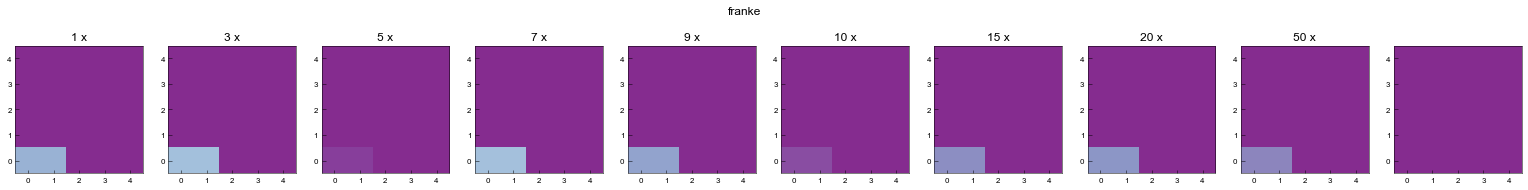

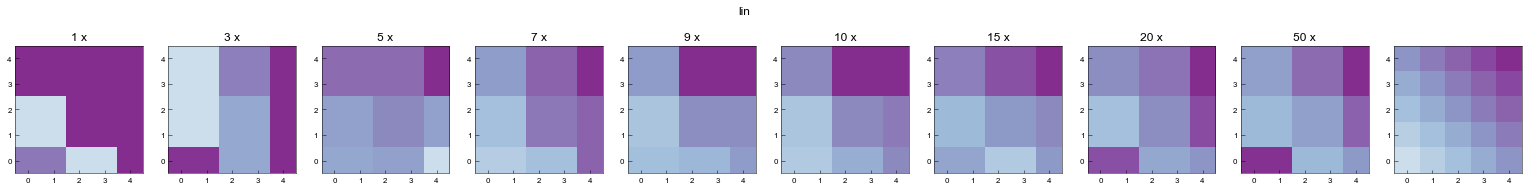

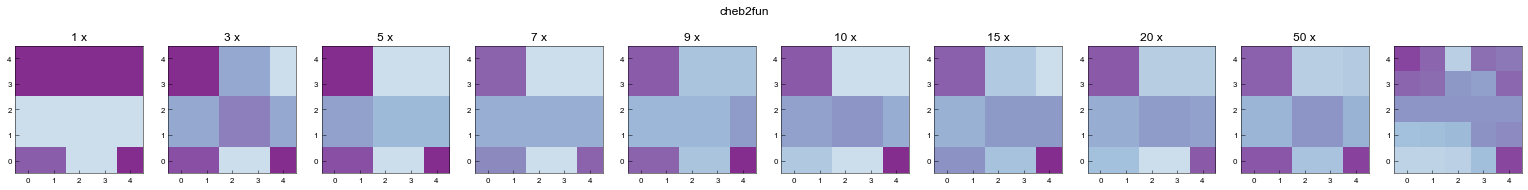

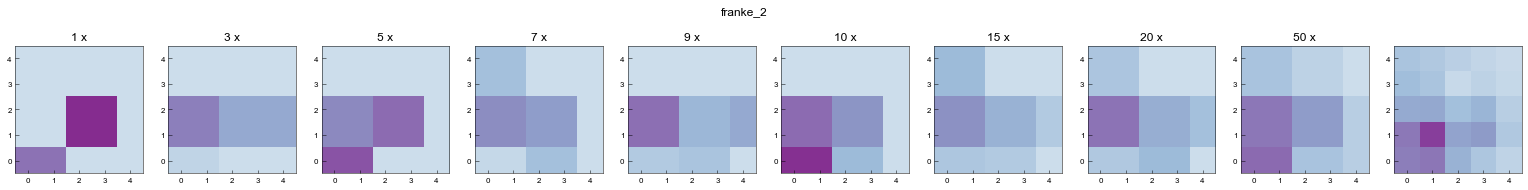

In [7]:
for idx_rotation in [0]:
    
    GROUP_ORIENTATION = GROUP_LIST[idx_rotation]
    
    SENSING_GRID_ORIENTATION = [tuple(item) for item in SENSING_LIST[idx_rotation].T]  
    TRUTHKWARGS["all_qubit_locations"] = SENSING_GRID_ORIENTATION + data_qubits
    

    for idx_truth in range(len(truth_types)):

        true_function_type = truth_types[idx_truth]

        TRUTHKWARGS["true_function_type"] = true_function_type

        fig, axes = plt.subplots(1,len(Multiples) + 1, figsize=(len(Multiples)*3, 3))

        fig.suptitle(true_function_type)

        for idx_msmt_var in range(len(Multiples)):    

            max_num_iterations= NUM_SENSING_NODES * Multiples[idx_msmt_var]

            for idx_run in range(trials):

                test_object = SimpleAssignmentEstimator(TRUTHKWARGS,
                                                        msmt_per_node=1,
                                                        numofnodes=num_of_nodes,
                                                        data_qubits_indicies=data_qubits_indicies,
                                                        intepolationflag=interpolation_flag,
                                                        max_num_iterations=max_num_iterations)

                estimated_vals, phase_map = test_object.get_empirical_est(GROUP_ORIENTATION)

                estimated_map_matrix[idx_truth, idx_msmt_var, idx_run, : ] = estimated_vals
                residuals_err_matrix[idx_truth, idx_msmt_var, idx_run, : ] = estimated_vals - phase_map

            axes[idx_msmt_var].imshow(estimated_vals[NUM_SENSING_NODES :].reshape(5,5), **HEATMAP)
            axes[idx_msmt_var].set_title("%s x" %(Multiples[idx_msmt_var]))

        axes[-1].imshow(phase_map[NUM_SENSING_NODES:].reshape(5,5),**HEATMAP)

        plt.show()

    np.savez('Local_Neighbourhood_Assignment_orientation_'+str(idx_rotation)+'.npz', 
             estimated_map_matrix=estimated_map_matrix, 
             residuals_err_matrix=residuals_err_matrix)